In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
)
from scipy.stats import randint, uniform

file_path = "sample_marketing_dataset.csv"
df = pd.read_csv(file_path)
print("Dataset loaded. Shape:", df.shape)
print(df.head(), "\n")

Dataset loaded. Shape: (10, 5)
   Age  Income  Previous_Response Channel  Response
0   25   45000                  1   Email         1
1   34   60000                  0     SMS         0
2   45   80000                  1   Email         1
3   23   32000                  0   Phone         0
4   36   55000                  1   Email         1 



In [7]:
df.columns = [c.strip() for c in df.columns]

target_col = "Response"
feature_cols = [c for c in df.columns if c != target_col]

numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_features:
    numeric_features.remove(target_col)
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)
print()

Numeric features: ['Age', 'Income', 'Previous_Response']
Categorical features: ['Channel']



In [8]:
X = df[feature_cols]
y = df[target_col].astype(int)  # ensure integer 0/1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [9]:
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

In [10]:
logreg_pipeline = Pipeline([
    ("preproc", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

rf_pipeline = Pipeline([
    ("preproc", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42))
])

gb_pipeline = Pipeline([
    ("preproc", preprocessor),
    ("clf", GradientBoostingClassifier(random_state=42))
])

models = {
    "Logistic Regression": logreg_pipeline,
    "Random Forest": rf_pipeline,
    "Gradient Boosting": gb_pipeline
}

In [11]:
def evaluate_model(pipeline, X_train, y_train, X_test, y_test, name=None, cv=5):
    try:
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="accuracy")
        cv_mean = cv_scores.mean()
    except Exception:
        cv_mean = np.nan

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_proba = None
    if hasattr(pipeline.named_steps['clf'], "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    elif hasattr(pipeline.named_steps['clf'], "decision_function"):
        y_pred_proba = pipeline.decision_function(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else np.nan

    print(f"\n=== {name or 'Model'} ===")
    print("Cross-val accuracy (train):", np.round(cv_mean, 4))
    print("Test Accuracy:", np.round(acc, 4))
    print("Precision:", np.round(prec, 4))
    print("Recall:", np.round(rec, 4))
    print("F1 Score:", np.round(f1, 4))
    print("ROC AUC:", np.round(roc_auc, 4) if not np.isnan(roc_auc) else "N/A")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return pipeline, y_pred_proba


=== Logistic Regression ===
Cross-val accuracy (train): 1.0
Test Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



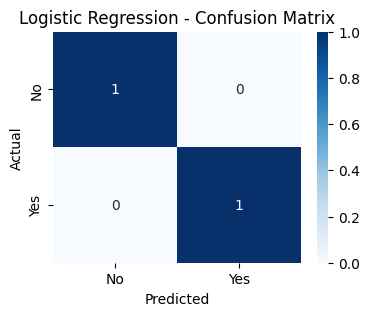


=== Random Forest ===
Cross-val accuracy (train): 0.8333
Test Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



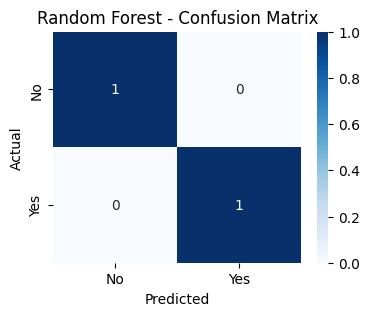


=== Gradient Boosting ===
Cross-val accuracy (train): 1.0
Test Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



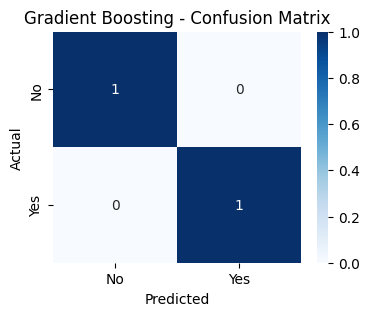

In [12]:
fitted_models = {}
probas = {}

for name, pipeline in models.items():
    fitted, y_prob = evaluate_model(pipeline, X_train, y_train, X_test, y_test, name=name, cv=3)
    fitted_models[name] = fitted
    probas[name] = y_prob

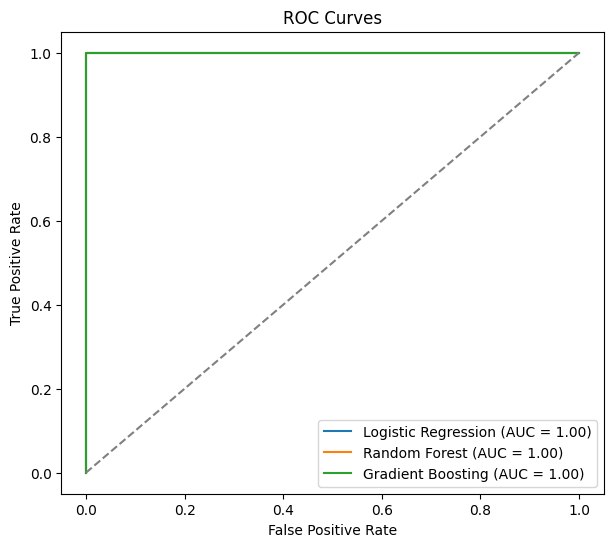

In [13]:
plt.figure(figsize=(7,6))
for name, y_prob in probas.items():
    if y_prob is None:
        continue
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

/tmp/ipython-input-602119063.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df, y="feature", x="importance", palette="viridis")


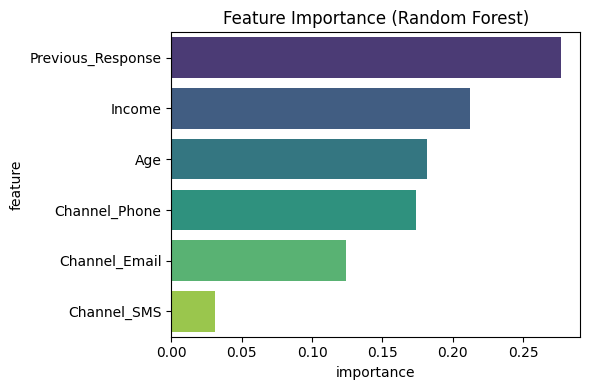

In [14]:
rf = fitted_models["Random Forest"]
num_names = numeric_features
ohe = rf.named_steps['preproc'].named_transformers_['cat'].named_steps['onehot']
if categorical_features:
    try:
        cat_names = ohe.get_feature_names_out(categorical_features).tolist()
    except Exception:
        cat_names = [f"{c}_{i}" for c in categorical_features for i in range(1)]
else:
    cat_names = []

feature_names = num_names + cat_names
importances = rf.named_steps['clf'].feature_importances_

if len(importances) == len(feature_names):
    fi_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)
else:
    fi_df = pd.DataFrame({"feature": num_names, "importance": importances[:len(num_names)]}).sort_values("importance", ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(data=fi_df, y="feature", x="importance", palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()



Best RF params: {'clf__bootstrap': True, 'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 4, 'clf__n_estimators': 156}

=== Tuned Random Forest ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
ROC AUC: 1.0


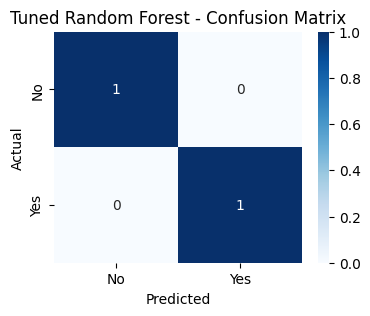

In [15]:
param_dist = {
    "clf__n_estimators": randint(50, 200),
    "clf__max_depth": randint(2, 10),
    "clf__min_samples_split": randint(2, 6),
    "clf__min_samples_leaf": randint(1, 4),
    "clf__bootstrap": [True, False]
}

rf_random = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring="accuracy",
    cv=3,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)
print("\nBest RF params:", rf_random.best_params_)
best_rf = rf_random.best_estimator_

y_pred_tuned = best_rf.predict(X_test)
y_pred_tuned_proba = best_rf.predict_proba(X_test)[:,1] if hasattr(best_rf.named_steps['clf'], "predict_proba") else None

print("\n=== Tuned Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Precision:", precision_score(y_test, y_pred_tuned, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_tuned, zero_division=0))
print("F1:", f1_score(y_test, y_pred_tuned, zero_division=0))
if y_pred_tuned_proba is not None:
    print("ROC AUC:", roc_auc_score(y_test, y_pred_tuned_proba))

cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("Tuned Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()